In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source


from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#targetName = "TwoStDayAfterMajRev"
targetName = "TwoStateMajorReversals"

2024-07-23 14:55:57.475338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 14:55:57.475404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 14:55:57.513945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 14:55:57.571508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target=targetName)
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
#targetdf.head()

(2371,)


# LSTM

Note that we do not have any offset data in the current dataset, so we can split cleanly, and won't get future information contaminating our current state.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(stockdf, y_orig, test_size=0.2,shuffle=False)

other_test = otherdf.iloc[-y_test.shape[0]:]

In [4]:
wandb.login(key="d2e07e8a9d7ef675859816d6e8230c50ccd2846d")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: candrews1971 (christopherandrews). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Base ROI

In [5]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])
bah_ROI

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 174.55, cash balance: $1137.7000000000003
Buying 8 shares for 138.34. Remaining Balance: 30.980000000000246
Selling all shares for 155.74, cash balance: $1276.9000000000003
Buying 9 shares for 134.87. Remaining Balance: 63.07000000000039
Selling all shares for 151.29, cash balance: $1424.6800000000003
Buying 11 shares for 125.02. Remaining Balance: 49.460000000000264
Selling all shares for 155.33, cash balance: $1758.0900000000004
Buying 12 shares for 145.31. Remaining Balance: 14.370000000000346
Selling all shares for 196.45, cash balance: $2371.77
Buying 13 shares for 174.00. Remaining Balance: 109.76999999999998
Selling all shares for 189.70, cash balance: $2575.87
Buying 15 shares for 171.21. Remaining Balance: 7.7199999999998
Selling all shares for 180.71, cash balance: $2718.37
Buying 16 shares for 166.89. Remaining Balance: 48.13000000000011
Selling all shares for 198.11, cash balance: $3217.

62.640000000000015

In [6]:
type(y_train)

pandas.core.series.Series

In [7]:
X_train.shape

(1896, 23)

# Inputs

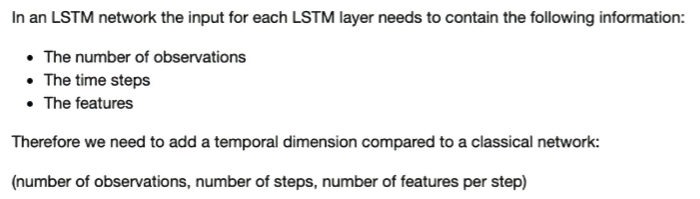

# Configuration

In [8]:
# first, set up our configuration (will be logged)
configs = dict(
    num_classes = 1,
    earlystopping_patience = 15,
    sequence_length = 5,
    epochs = 75,
    optimizer = 'nadam',
    learning_rate = 0.0005,
    targetName = targetName,
    batch_size = 16,
)

## Create Sequences

In [9]:
y_test_orig = y_test.copy()

# Convert y to numbers
y_train= pd.Categorical(y_train).codes
y_test= pd.Categorical(y_test).codes
y_orig= pd.Categorical(y_orig).codes

In [10]:
type(y_train)

numpy.ndarray

In [11]:
# First, we have to convert our dataframes to numpy arrays

X_train = X_train.values
#y_train = y_train.to_numpy() #conversion to categorical (above) does this for us

X_test = X_test.values
#y_test = y_test.to_numpy()

X_orig = stockdf.values
#y_orig = y_orig.to_numpy()

In [12]:
assert(len(X_orig) == len(X_train) + len(X_test))
len(X_orig)

2371

In [13]:
type(X_train)


numpy.ndarray

In [14]:
seq_length = configs['sequence_length']

Xtr = []
ytr = []
Xt = []
yt = []
Xo= []
yo = []
for i in range(seq_length, len(X_train)):
    Xtr.append(X_train[i -seq_length: i, :X_train.shape[1]])
    ytr.append(y_train[i])# starts appending at 0.  Can we use shift() instead? 
# do the same for Xt, yt
for i in range(seq_length, len(X_test)):
    Xt.append(X_test[i -seq_length: i, :X_test.shape[1]])
    yt.append(y_test[i])
for i in range(seq_length, len(X_orig)):
    Xo.append(X_orig[i -seq_length: i, :X_orig.shape[1]])
    yo.append(y_orig[i])

In [15]:
# convert to np arrays again
Xtr = np.array(Xtr)
ytr = np.array(ytr)
Xt = np.array(Xt)
yt = np.array(yt)
Xo = np.array(Xo)
yo = np.array(yo)

Okay, so now we have the data in the shape we need  (num_observations, seq_length, num_features)

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense 
from keras.optimizers import Nadam, Adam

optimizer = Nadam(learning_rate=configs['learning_rate'])

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(Xtr.shape[1], Xtr.shape[2]), name="Where_is_my_mind")) #Pixies lyric references for names!  completely unintentional, but funny!
#model.add(Dense(16, activation='sigmoid'))
model.add(Dense(configs["num_classes"], activation='sigmoid', name="Im_So_Dense"))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

2024-07-23 14:56:05.214607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:56:05.223417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:56:05.223508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:56:05.231693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-23 14:56:05.231805: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Where_is_my_mind (LSTM)     (None, 50)                14800     
                                                                 
 Im_So_Dense (Dense)         (None, 1)                 51        
                                                                 
Total params: 14851 (58.01 KB)
Trainable params: 14851 (58.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


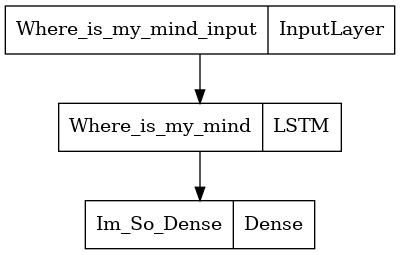

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="StockLSTM_Model.png")

Set up early stopping so we don't go too long

In [18]:
from keras.callbacks import EarlyStopping
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

es = EarlyStopping(monitor='accuracy', patience=configs['earlystopping_patience'])



In [19]:
#log to weights and biases
run_name = f"LSTMClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=configs)

callbacks = [es, WandbMetricsLogger(), WandbModelCheckpoint("models")]

In [20]:
history = model.fit(Xtr, 
                    ytr, 
                    epochs=configs['epochs'], 
                    validation_data=(Xt, yt), 
                    batch_size=configs['batch_size'], 
                    verbose=1, 
                    callbacks=callbacks,
                    )

run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI



Epoch 1/75


2024-07-23 14:56:29.654491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-23 14:56:30.298376: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efac4ef0ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 14:56:30.298432: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-07-23 14:56:30.329135: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721768190.501645 3168507 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/119 [============================>.] - ETA: 0s - loss: 0.6096 - accuracy: 0.6944INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 38ms/step - loss: 0.6092 - accuracy: 0.6949 - val_loss: 0.7033 - val_accuracy: 0.5532
Epoch 2/75
119/119 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.6954INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 42ms/step - loss: 0.5958 - accuracy: 0.6954 - val_loss: 0.6947 - val_accuracy: 0.5532
Epoch 3/75
117/119 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.6955INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.5858 - accuracy: 0.6965 - val_loss: 0.6949 - val_accuracy: 0.5532
Epoch 4/75
114/119 [===========================>..] - ETA: 0s - loss: 0.5783 - accuracy: 0.6996INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.5777 - accuracy: 0.7002 - val_loss: 0.6838 - val_accuracy: 0.5532
Epoch 5/75
117/119 [============================>.] - ETA: 0s - loss: 0.5675 - accuracy: 0.7041INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.5662 - accuracy: 0.7060 - val_loss: 0.6920 - val_accuracy: 0.5532
Epoch 6/75
117/119 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.7115INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.5534 - accuracy: 0.7113 - val_loss: 0.6737 - val_accuracy: 0.5553
Epoch 7/75
115/119 [===========================>..] - ETA: 0s - loss: 0.5276 - accuracy: 0.7342INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.5284 - accuracy: 0.7329 - val_loss: 0.6570 - val_accuracy: 0.5936
Epoch 8/75
117/119 [============================>.] - ETA: 0s - loss: 0.5167 - accuracy: 0.7463INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.5160 - accuracy: 0.7462 - val_loss: 0.6570 - val_accuracy: 0.5468
Epoch 9/75
118/119 [============================>.] - ETA: 0s - loss: 0.5031 - accuracy: 0.7595INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.5038 - accuracy: 0.7594 - val_loss: 0.6817 - val_accuracy: 0.5511
Epoch 10/75
119/119 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.7636INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.5008 - accuracy: 0.7636 - val_loss: 0.6647 - val_accuracy: 0.5809
Epoch 11/75
119/119 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.7668INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.4925 - accuracy: 0.7668 - val_loss: 0.6573 - val_accuracy: 0.5872
Epoch 12/75
118/119 [============================>.] - ETA: 0s - loss: 0.4893 - accuracy: 0.7691INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.4890 - accuracy: 0.7694 - val_loss: 0.6508 - val_accuracy: 0.5702
Epoch 13/75
119/119 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7784INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.4871 - accuracy: 0.7784 - val_loss: 0.6401 - val_accuracy: 0.6043
Epoch 14/75
118/119 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.7812INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.4761 - accuracy: 0.7816 - val_loss: 0.6412 - val_accuracy: 0.6064
Epoch 15/75
118/119 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.7733INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.4748 - accuracy: 0.7731 - val_loss: 0.6915 - val_accuracy: 0.5404
Epoch 16/75
119/119 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.7753INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 43ms/step - loss: 0.4747 - accuracy: 0.7753 - val_loss: 0.6272 - val_accuracy: 0.6426
Epoch 17/75
119/119 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7779INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 48ms/step - loss: 0.4700 - accuracy: 0.7779 - val_loss: 0.6841 - val_accuracy: 0.5574
Epoch 18/75
118/119 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.7940INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.4576 - accuracy: 0.7932 - val_loss: 0.6611 - val_accuracy: 0.6085
Epoch 19/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4601 - accuracy: 0.7897INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.4589 - accuracy: 0.7906 - val_loss: 0.6520 - val_accuracy: 0.6362
Epoch 20/75
117/119 [============================>.] - ETA: 0s - loss: 0.4560 - accuracy: 0.7949INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.4557 - accuracy: 0.7948 - val_loss: 0.6547 - val_accuracy: 0.6191
Epoch 21/75
117/119 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.7895INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.4495 - accuracy: 0.7890 - val_loss: 0.6517 - val_accuracy: 0.6447
Epoch 22/75
117/119 [============================>.] - ETA: 0s - loss: 0.4475 - accuracy: 0.7943INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.4462 - accuracy: 0.7948 - val_loss: 0.6528 - val_accuracy: 0.6362
Epoch 23/75
116/119 [============================>.] - ETA: 0s - loss: 0.4413 - accuracy: 0.7904INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.4407 - accuracy: 0.7911 - val_loss: 0.6433 - val_accuracy: 0.6426
Epoch 24/75
117/119 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.7970INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.4386 - accuracy: 0.7980 - val_loss: 0.6521 - val_accuracy: 0.6106
Epoch 25/75
118/119 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.7956INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 44ms/step - loss: 0.4387 - accuracy: 0.7953 - val_loss: 0.6319 - val_accuracy: 0.6362
Epoch 26/75
119/119 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.8001INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.4320 - accuracy: 0.8001 - val_loss: 0.6585 - val_accuracy: 0.6106
Epoch 27/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4313 - accuracy: 0.7929INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.4306 - accuracy: 0.7932 - val_loss: 0.6444 - val_accuracy: 0.6043
Epoch 28/75
119/119 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8043INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.4312 - accuracy: 0.8043 - val_loss: 0.6630 - val_accuracy: 0.5872
Epoch 29/75
118/119 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8008INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.4226 - accuracy: 0.8012 - val_loss: 0.6506 - val_accuracy: 0.6404
Epoch 30/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4201 - accuracy: 0.8043INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 38ms/step - loss: 0.4168 - accuracy: 0.8070 - val_loss: 0.6089 - val_accuracy: 0.6766
Epoch 31/75
118/119 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8162INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.4131 - accuracy: 0.8154 - val_loss: 0.6279 - val_accuracy: 0.5936
Epoch 32/75
119/119 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8154INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 43ms/step - loss: 0.4068 - accuracy: 0.8154 - val_loss: 0.6435 - val_accuracy: 0.6021
Epoch 33/75
119/119 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8149INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.4103 - accuracy: 0.8149 - val_loss: 0.6609 - val_accuracy: 0.5872
Epoch 34/75
116/119 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8120INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.4064 - accuracy: 0.8133 - val_loss: 0.6452 - val_accuracy: 0.6213
Epoch 35/75
119/119 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8065INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 33ms/step - loss: 0.4048 - accuracy: 0.8065 - val_loss: 0.6566 - val_accuracy: 0.6128
Epoch 36/75
119/119 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8107INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 43ms/step - loss: 0.3965 - accuracy: 0.8107 - val_loss: 0.6530 - val_accuracy: 0.6213
Epoch 37/75
117/119 [============================>.] - ETA: 0s - loss: 0.3947 - accuracy: 0.8184INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3950 - accuracy: 0.8186 - val_loss: 0.6401 - val_accuracy: 0.6191
Epoch 38/75
116/119 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8163INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3908 - accuracy: 0.8165 - val_loss: 0.6775 - val_accuracy: 0.5553
Epoch 39/75
116/119 [============================>.] - ETA: 0s - loss: 0.3885 - accuracy: 0.8217INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3884 - accuracy: 0.8234 - val_loss: 0.6475 - val_accuracy: 0.6404
Epoch 40/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3861 - accuracy: 0.8228INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 47ms/step - loss: 0.3860 - accuracy: 0.8228 - val_loss: 0.6425 - val_accuracy: 0.6340
Epoch 41/75
116/119 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8227INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.3815 - accuracy: 0.8223 - val_loss: 0.6361 - val_accuracy: 0.6447
Epoch 42/75
117/119 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8259INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 44ms/step - loss: 0.3769 - accuracy: 0.8271 - val_loss: 0.6895 - val_accuracy: 0.5447
Epoch 43/75
119/119 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8239INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3753 - accuracy: 0.8239 - val_loss: 0.6849 - val_accuracy: 0.5660
Epoch 44/75
116/119 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8281INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 47ms/step - loss: 0.3741 - accuracy: 0.8276 - val_loss: 0.7375 - val_accuracy: 0.5106
Epoch 45/75
119/119 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8276INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3746 - accuracy: 0.8276 - val_loss: 0.7011 - val_accuracy: 0.5745
Epoch 46/75
116/119 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8330INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3670 - accuracy: 0.8324 - val_loss: 0.6916 - val_accuracy: 0.5532
Epoch 47/75
114/119 [===========================>..] - ETA: 0s - loss: 0.3768 - accuracy: 0.8185INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3749 - accuracy: 0.8202 - val_loss: 0.6597 - val_accuracy: 0.6426
Epoch 48/75
117/119 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8259INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.3706 - accuracy: 0.8265 - val_loss: 0.7163 - val_accuracy: 0.5723
Epoch 49/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3697 - accuracy: 0.8337INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 51ms/step - loss: 0.3712 - accuracy: 0.8313 - val_loss: 0.7010 - val_accuracy: 0.5681
Epoch 50/75
118/119 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8294INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.3631 - accuracy: 0.8297 - val_loss: 0.6376 - val_accuracy: 0.6574
Epoch 51/75
116/119 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8335INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 40ms/step - loss: 0.3569 - accuracy: 0.8340 - val_loss: 0.6015 - val_accuracy: 0.6553
Epoch 52/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3559 - accuracy: 0.8413INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.3559 - accuracy: 0.8403 - val_loss: 0.6407 - val_accuracy: 0.6213
Epoch 53/75
119/119 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8345INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 38ms/step - loss: 0.3555 - accuracy: 0.8345 - val_loss: 0.7390 - val_accuracy: 0.5255
Epoch 54/75
118/119 [============================>.] - ETA: 0s - loss: 0.3608 - accuracy: 0.8379INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 41ms/step - loss: 0.3605 - accuracy: 0.8382 - val_loss: 0.6650 - val_accuracy: 0.5851
Epoch 55/75
116/119 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.8432INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 42ms/step - loss: 0.3450 - accuracy: 0.8429 - val_loss: 0.6237 - val_accuracy: 0.6191
Epoch 56/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3450 - accuracy: 0.8391INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3466 - accuracy: 0.8392 - val_loss: 0.6697 - val_accuracy: 0.6000
Epoch 57/75
115/119 [===========================>..] - ETA: 0s - loss: 0.3459 - accuracy: 0.8533INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3468 - accuracy: 0.8514 - val_loss: 0.6032 - val_accuracy: 0.6809
Epoch 58/75
118/119 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8400INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 36ms/step - loss: 0.3422 - accuracy: 0.8403 - val_loss: 0.7087 - val_accuracy: 0.5723
Epoch 59/75
118/119 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8416INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 44ms/step - loss: 0.3430 - accuracy: 0.8414 - val_loss: 0.6063 - val_accuracy: 0.6638
Epoch 60/75
118/119 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8443INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3370 - accuracy: 0.8445 - val_loss: 0.6722 - val_accuracy: 0.5638
Epoch 61/75
117/119 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8483INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 35ms/step - loss: 0.3369 - accuracy: 0.8472 - val_loss: 0.6175 - val_accuracy: 0.6383
Epoch 62/75
117/119 [============================>.] - ETA: 0s - loss: 0.3313 - accuracy: 0.8472INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3303 - accuracy: 0.8477 - val_loss: 0.6564 - val_accuracy: 0.6128
Epoch 63/75
119/119 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8498INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


119/119 [==============================] - 25s 213ms/step - loss: 0.3387 - accuracy: 0.8498 - val_loss: 0.6623 - val_accuracy: 0.6128
Epoch 64/75
118/119 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.8543INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 49ms/step - loss: 0.3319 - accuracy: 0.8546 - val_loss: 0.6415 - val_accuracy: 0.5851
Epoch 65/75
118/119 [============================>.] - ETA: 0s - loss: 0.3292 - accuracy: 0.8506INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.3299 - accuracy: 0.8503 - val_loss: 0.6839 - val_accuracy: 0.5553
Epoch 66/75
116/119 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8615INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3193 - accuracy: 0.8604 - val_loss: 0.7173 - val_accuracy: 0.5809
Epoch 67/75
118/119 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8570INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 42ms/step - loss: 0.3220 - accuracy: 0.8572 - val_loss: 0.6698 - val_accuracy: 0.5851
Epoch 68/75
118/119 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8570INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 42ms/step - loss: 0.3183 - accuracy: 0.8562 - val_loss: 0.7027 - val_accuracy: 0.5979
Epoch 69/75
118/119 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8607INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 34ms/step - loss: 0.3201 - accuracy: 0.8609 - val_loss: 0.6312 - val_accuracy: 0.6319
Epoch 70/75
118/119 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.8543INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3178 - accuracy: 0.8540 - val_loss: 0.6196 - val_accuracy: 0.6489
Epoch 71/75
117/119 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8638INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 39ms/step - loss: 0.3117 - accuracy: 0.8630 - val_loss: 0.6340 - val_accuracy: 0.5894
Epoch 72/75
119/119 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8604INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 38ms/step - loss: 0.3080 - accuracy: 0.8604 - val_loss: 0.6667 - val_accuracy: 0.5787
Epoch 73/75
119/119 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8636INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 5s 38ms/step - loss: 0.3087 - accuracy: 0.8636 - val_loss: 0.6717 - val_accuracy: 0.5617
Epoch 74/75
117/119 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8579INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 4s 37ms/step - loss: 0.3081 - accuracy: 0.8593 - val_loss: 0.6660 - val_accuracy: 0.5638
Epoch 75/75
116/119 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8637INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 6s 47ms/step - loss: 0.3026 - accuracy: 0.8636 - val_loss: 0.6380 - val_accuracy: 0.6021


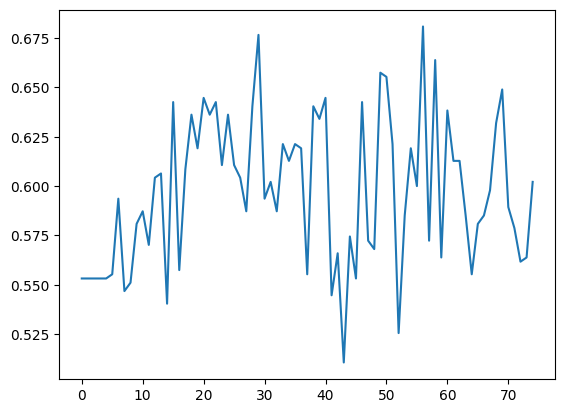

In [21]:
plt.figure()
plt.plot(history.history['val_accuracy'])

In [22]:
Xtp = Xo.copy()

In [23]:
#predictions
testPred = model.predict(Xt)
trainPred = model.predict(Xtr)
fullPred = model.predict(Xo)

#pPred = model.predict(Xtp)

#pPred = np.c_[pPred, np.zeros(pPred.shape)]

74/74 [==============================] - 0s 4ms/step


In [24]:
testPred = np.round(testPred)
trainPred= np.round(trainPred)
fullPred = np.round(fullPred)



In [25]:
y_test_orig = y_test_orig[configs['sequence_length']:]

In [26]:

lstm_preds = pd.DataFrame(data=testPred, columns=["Target"], index=y_test_orig.index.copy())
lstm_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])


Buying 6 shares for 160.01. Remaining Balance: 39.940000000000055
Selling all shares for 161.38, cash balance: $1008.22
Buying 6 shares for 154.53. Remaining Balance: 81.03999999999996
Selling all shares for 155.96, cash balance: $1016.8
Buying 6 shares for 154.46. Remaining Balance: 90.03999999999996
Selling all shares for 155.31, cash balance: $1021.9
Buying 6 shares for 152.37. Remaining Balance: 107.67999999999995
Selling all shares for 152.74, cash balance: $1024.12
Buying 7 shares for 142.48. Remaining Balance: 26.75999999999999
Selling all shares for 138.20, cash balance: $994.1599999999999
Buying 6 shares for 146.10. Remaining Balance: 117.55999999999995
Selling all shares for 140.09, cash balance: $958.0999999999999
Buying 6 shares for 143.86. Remaining Balance: 94.93999999999983
Selling all shares for 134.51, cash balance: $901.9999999999998
Buying 6 shares for 135.45. Remaining Balance: 89.29999999999984
Selling all shares for 129.61, cash balance: $866.9599999999999
Buying 

In [27]:
y_test_orig_array = pd.Categorical(y_test_orig).codes
len(y_test_orig_array)

470

In [28]:
run.summary['accuracy'] = accuracy_score(y_test_orig_array, testPred)
wandb.sklearn.plot_confusion_matrix(y_test_orig_array, testPred, ["BUY", "SELL"])



In [29]:
run.finish()

epoch/accuracy,▁▁▁▂▃▄▄▅▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▃▃▃▃▂▄▃▅▆▅▆▇▆▆▅▆▄▄▅▅▃▆▂▁▃▄▇▆▄▅█▇▆▅▃▄▆▄▃▅
epoch/val_loss,▆▆▅▅▄▄▃▃▂▄▄▄▃▂▃▃▂▄▄▃▅▃▅█▆▇▃▃▄▄▁▁▂▄▅▄▂▃▅▃
Buy And Hold (Base ROI),62.64
Max ROI,3415.19
ROI,165.66
accuracy,0.60213
epoch/accuracy,0.86356


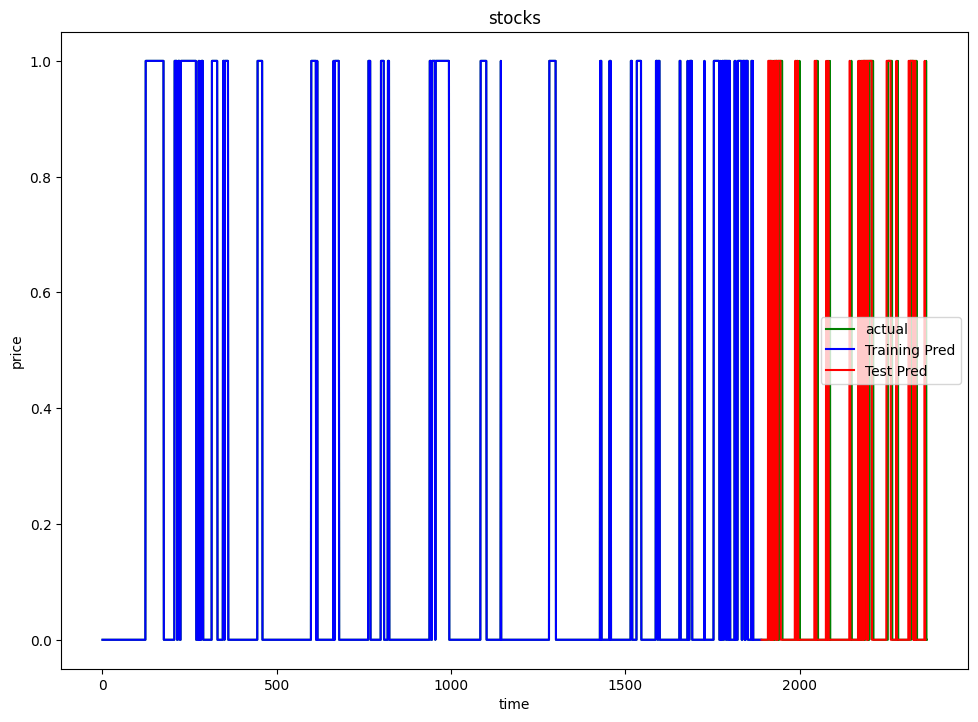

In [30]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

xshift = np.linspace(start=len(trainPred), stop=len(trainPred)+len(testPred),num=len(testPred))

plt.plot(fullPred, 'g', label="actual")
plt.plot(trainPred, "b", label="Training Pred")
plt.plot(xshift, testPred, 'r',label="Test Pred")
#plt.plot(xshift, pPred, 'k',label="REAL Pred")

#plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("stocks")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()

In [31]:
lstm_predictions = targetdf.copy()
lstm_predictions['close'] = otherdf['close']

lstm_predictions = lstm_predictions[configs['sequence_length']:]

In [32]:

lstm_predictions['Target'] = fullPred

lstm_predictions.head()

,Target,close
date,,
1/21/2015,0.0,27.3875
1/22/2015,0.0,28.1000
1/23/2015,0.0,28.2450
1/26/2015,0.0,28.2750
1/27/2015,0.0,27.2850


In [33]:
stockutils.calculate_total_gains_bs(lstm_predictions, init_value=1000, init_price=lstm_predictions['close'][0])

Buying 36 shares for 27.39. Remaining Balance: 14.050000000000068
Selling all shares for 33.02, cash balance: $1202.6799999999998
Buying 43 shares for 27.39. Remaining Balance: 24.694999999999936
Selling all shares for 28.09, cash balance: $1232.35
Buying 41 shares for 29.72. Remaining Balance: 13.829999999999927
Selling all shares for 29.57, cash balance: $1226.405
Buying 41 shares for 29.57. Remaining Balance: 14.034999999999854
Selling all shares for 29.04, cash balance: $1204.7775
Buying 49 shares for 24.16. Remaining Balance: 20.9375
Selling all shares for 24.19, cash balance: $1206.2475000000002
Buying 49 shares for 24.23. Remaining Balance: 19.100000000000136
Selling all shares for 25.13, cash balance: $1250.5925000000002
Buying 49 shares for 25.19. Remaining Balance: 16.4050000000002
Selling all shares for 25.26, cash balance: $1254.0225000000003
Buying 47 shares for 26.14. Remaining Balance: 25.20750000000021
Selling all shares for 26.78, cash balance: $1283.9850000000001
Buyi

27180.607500000006

<Axes: xlabel='date', ylabel='close'>

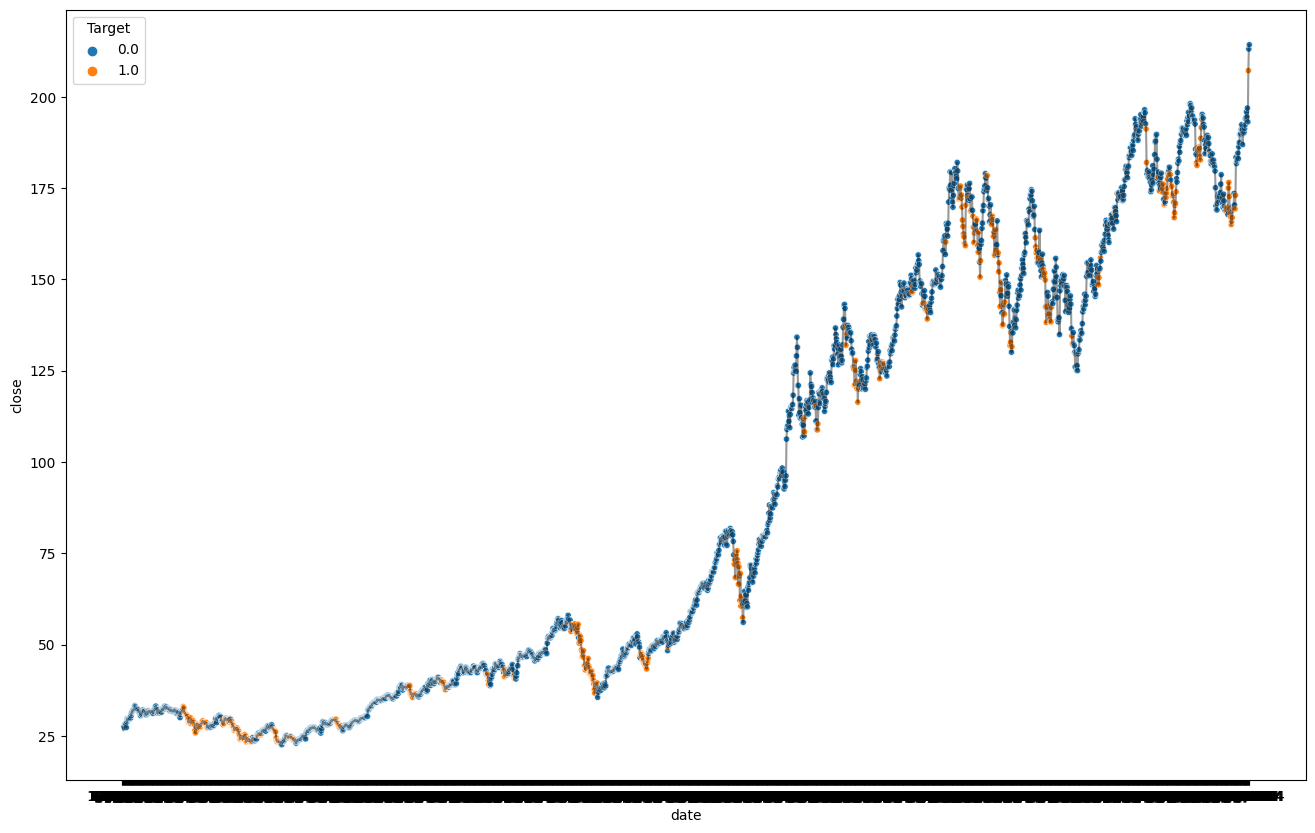

In [34]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=lstm_predictions, x=lstm_predictions.index, y='close', hue='Target',s=20)


If we were predicting price, based on price, we run into a problem where we need to convert our test data to be predictions based on the training data, and compare that to reality.  For Buy/Sell signals, there is no dependency on previous buy/sell signals (there still is price, but test dat is real data with no dependency on buy/sell signals)

# LSTM Stacked Model - more than one layer of LSTM

In [35]:
# LSTM Stacked model 

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Softmax, BatchNormalization
from keras.optimizers import Adam, Nadam

samples = Xtr.shape[0]
timesteps = Xtr.shape[1]
features = Xtr.shape[2]

optimizer = Nadam(learning_rate=configs['learning_rate'])

model = Sequential()
#model.add(LSTM(50, activation='tanh', input_shape=(timesteps, features), name="LSTM_0", return_sequences=True)) 
# model.add(Dropout(0.2))
model.add(LSTM(features*4, activation='tanh', input_shape=(timesteps, features), name="LSTM_1", return_sequences=True)) 
# model.add(Dropout(0.2))
# model.add(LSTM(100, activation='tanh', input_shape=(timesteps, features), name="LSTM_2", return_sequences=True)) 
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(50, activation='tanh', input_shape=(timesteps, features), name="LSTM_3", return_sequences=True)) 
# model.add(Dropout(0.2))

model.add(LSTM(features*2, activation='tanh', input_shape=(timesteps, features), name="LSTM_4")) 
#model.add(Dense(8, activation='ReLU', name="Features"))
model.add(Dense(configs['num_classes'], activation='sigmoid', name="Dense_Layer"))
#model.add(Softmax()) #this kills any learning, apparently

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 5, 92)             42688     
                                                                 
 LSTM_4 (LSTM)               (None, 46)                25576     
                                                                 
 Dense_Layer (Dense)         (None, 1)                 47        
                                                                 
Total params: 68311 (266.84 KB)
Trainable params: 68311 (266.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
run_name = f"StackedLSTMClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=configs)

callbacks = [es, WandbMetricsLogger(), WandbModelCheckpoint("models")]

In [37]:
history = model.fit(Xtr, 
                    ytr, 
                    epochs=configs['epochs'], 
                    validation_data=(Xt, yt), 
                    batch_size=configs['batch_size'], 
                    verbose=1, 
                    callbacks=callbacks,
                    )

run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

Epoch 1/75
118/119 [============================>.] - ETA: 0s - loss: 0.6022 - accuracy: 0.6917INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 12s 64ms/step - loss: 0.6020 - accuracy: 0.6917 - val_loss: 0.6817 - val_accuracy: 0.5915
Epoch 2/75
117/119 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.6971INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 42s 155ms/step - loss: 0.5667 - accuracy: 0.6986 - val_loss: 0.6696 - val_accuracy: 0.5532
Epoch 3/75
117/119 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.7361INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 45s 379ms/step - loss: 0.5380 - accuracy: 0.7356 - val_loss: 0.6685 - val_accuracy: 0.5340
Epoch 4/75
119/119 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.7509INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 58ms/step - loss: 0.5179 - accuracy: 0.7509 - val_loss: 0.6573 - val_accuracy: 0.6702
Epoch 5/75
119/119 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.7599INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 69ms/step - loss: 0.5069 - accuracy: 0.7599 - val_loss: 0.6481 - val_accuracy: 0.5660
Epoch 6/75
116/119 [============================>.] - ETA: 0s - loss: 0.4966 - accuracy: 0.7565INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 58ms/step - loss: 0.4954 - accuracy: 0.7578 - val_loss: 0.6471 - val_accuracy: 0.6000
Epoch 7/75
116/119 [============================>.] - ETA: 0s - loss: 0.4907 - accuracy: 0.7759INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 63ms/step - loss: 0.4906 - accuracy: 0.7747 - val_loss: 0.6384 - val_accuracy: 0.6426
Epoch 8/75
118/119 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.7717INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 73ms/step - loss: 0.4812 - accuracy: 0.7715 - val_loss: 0.6493 - val_accuracy: 0.6447
Epoch 9/75
118/119 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.7781INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 11s 94ms/step - loss: 0.4762 - accuracy: 0.7784 - val_loss: 0.6444 - val_accuracy: 0.6213
Epoch 10/75
117/119 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7911INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.4677 - accuracy: 0.7911 - val_loss: 0.7012 - val_accuracy: 0.5106
Epoch 11/75
116/119 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.7909INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 72ms/step - loss: 0.4558 - accuracy: 0.7890 - val_loss: 0.6299 - val_accuracy: 0.6489
Epoch 12/75
117/119 [============================>.] - ETA: 0s - loss: 0.4597 - accuracy: 0.7837INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 57ms/step - loss: 0.4600 - accuracy: 0.7832 - val_loss: 0.6588 - val_accuracy: 0.6213
Epoch 13/75
117/119 [============================>.] - ETA: 0s - loss: 0.4594 - accuracy: 0.7794INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 60ms/step - loss: 0.4575 - accuracy: 0.7811 - val_loss: 0.6343 - val_accuracy: 0.6213
Epoch 14/75
119/119 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.7890INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 77ms/step - loss: 0.4471 - accuracy: 0.7890 - val_loss: 0.6686 - val_accuracy: 0.5468
Epoch 15/75
116/119 [============================>.] - ETA: 0s - loss: 0.4426 - accuracy: 0.7947INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 64ms/step - loss: 0.4419 - accuracy: 0.7959 - val_loss: 0.6357 - val_accuracy: 0.6404
Epoch 16/75
118/119 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8008INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 63ms/step - loss: 0.4343 - accuracy: 0.8012 - val_loss: 0.6354 - val_accuracy: 0.6681
Epoch 17/75
115/119 [===========================>..] - ETA: 0s - loss: 0.4277 - accuracy: 0.8016INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 74ms/step - loss: 0.4280 - accuracy: 0.8012 - val_loss: 0.6588 - val_accuracy: 0.5660
Epoch 18/75
117/119 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.7943INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.4323 - accuracy: 0.7948 - val_loss: 0.6409 - val_accuracy: 0.6426
Epoch 19/75
116/119 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.7942INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.4269 - accuracy: 0.7943 - val_loss: 0.7075 - val_accuracy: 0.5532
Epoch 20/75
117/119 [============================>.] - ETA: 0s - loss: 0.4203 - accuracy: 0.7970INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 67ms/step - loss: 0.4217 - accuracy: 0.7948 - val_loss: 0.6491 - val_accuracy: 0.6149
Epoch 21/75
119/119 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8149INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 69ms/step - loss: 0.4083 - accuracy: 0.8149 - val_loss: 0.6317 - val_accuracy: 0.6255
Epoch 22/75
118/119 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8077INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 61ms/step - loss: 0.4061 - accuracy: 0.8075 - val_loss: 0.6462 - val_accuracy: 0.6064
Epoch 23/75
119/119 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8117INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 64ms/step - loss: 0.4077 - accuracy: 0.8117 - val_loss: 0.6712 - val_accuracy: 0.5426
Epoch 24/75
118/119 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.8162INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 70ms/step - loss: 0.3980 - accuracy: 0.8165 - val_loss: 0.6507 - val_accuracy: 0.6170
Epoch 25/75
116/119 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8098INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.4018 - accuracy: 0.8107 - val_loss: 0.6536 - val_accuracy: 0.6149
Epoch 26/75
119/119 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.8154INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 77ms/step - loss: 0.4000 - accuracy: 0.8154 - val_loss: 0.6841 - val_accuracy: 0.5851
Epoch 27/75
117/119 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8194INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 74ms/step - loss: 0.3924 - accuracy: 0.8191 - val_loss: 0.6760 - val_accuracy: 0.5894
Epoch 28/75
118/119 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8114INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 19s 159ms/step - loss: 0.3922 - accuracy: 0.8112 - val_loss: 0.6525 - val_accuracy: 0.5787
Epoch 29/75
117/119 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8226INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 63ms/step - loss: 0.3838 - accuracy: 0.8234 - val_loss: 0.6537 - val_accuracy: 0.6149
Epoch 30/75
116/119 [============================>.] - ETA: 0s - loss: 0.3885 - accuracy: 0.8168INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 68ms/step - loss: 0.3879 - accuracy: 0.8170 - val_loss: 0.6415 - val_accuracy: 0.6106
Epoch 31/75
116/119 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8147INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 60ms/step - loss: 0.3808 - accuracy: 0.8160 - val_loss: 0.6459 - val_accuracy: 0.6532
Epoch 32/75
118/119 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8226INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 19s 157ms/step - loss: 0.3683 - accuracy: 0.8223 - val_loss: 0.6763 - val_accuracy: 0.5660
Epoch 33/75
116/119 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8281INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 79ms/step - loss: 0.3658 - accuracy: 0.8302 - val_loss: 0.6427 - val_accuracy: 0.6128
Epoch 34/75
117/119 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8232INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 74ms/step - loss: 0.3691 - accuracy: 0.8234 - val_loss: 0.6272 - val_accuracy: 0.6489
Epoch 35/75
117/119 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8243INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 70ms/step - loss: 0.3707 - accuracy: 0.8255 - val_loss: 0.6631 - val_accuracy: 0.6277
Epoch 36/75
119/119 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8318INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 66ms/step - loss: 0.3551 - accuracy: 0.8318 - val_loss: 0.6642 - val_accuracy: 0.6106
Epoch 37/75
116/119 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8373INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 57ms/step - loss: 0.3435 - accuracy: 0.8382 - val_loss: 0.6360 - val_accuracy: 0.6170
Epoch 38/75
116/119 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8405INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 78ms/step - loss: 0.3415 - accuracy: 0.8414 - val_loss: 0.7347 - val_accuracy: 0.5660
Epoch 39/75
118/119 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8342INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 67ms/step - loss: 0.3461 - accuracy: 0.8340 - val_loss: 0.6803 - val_accuracy: 0.5766
Epoch 40/75
118/119 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8400INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 58ms/step - loss: 0.3412 - accuracy: 0.8398 - val_loss: 0.6737 - val_accuracy: 0.5723
Epoch 41/75
119/119 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8429INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 63ms/step - loss: 0.3381 - accuracy: 0.8429 - val_loss: 0.6532 - val_accuracy: 0.5787
Epoch 42/75
119/119 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8456INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 61ms/step - loss: 0.3249 - accuracy: 0.8456 - val_loss: 0.6628 - val_accuracy: 0.6191
Epoch 43/75
117/119 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8435INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 57ms/step - loss: 0.3358 - accuracy: 0.8435 - val_loss: 0.6475 - val_accuracy: 0.5766
Epoch 44/75
116/119 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8475INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 61ms/step - loss: 0.3198 - accuracy: 0.8477 - val_loss: 0.6478 - val_accuracy: 0.5851
Epoch 45/75
116/119 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8486INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 64ms/step - loss: 0.3159 - accuracy: 0.8488 - val_loss: 0.6519 - val_accuracy: 0.6043
Epoch 46/75
119/119 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8556INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.3067 - accuracy: 0.8556 - val_loss: 0.6916 - val_accuracy: 0.5872
Epoch 47/75
118/119 [============================>.] - ETA: 0s - loss: 0.3117 - accuracy: 0.8559INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 57ms/step - loss: 0.3112 - accuracy: 0.8562 - val_loss: 0.6666 - val_accuracy: 0.5681
Epoch 48/75
116/119 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8578INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 63ms/step - loss: 0.3024 - accuracy: 0.8577 - val_loss: 0.6704 - val_accuracy: 0.5766
Epoch 49/75
119/119 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8657INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 63ms/step - loss: 0.2975 - accuracy: 0.8657 - val_loss: 0.6752 - val_accuracy: 0.5596
Epoch 50/75
117/119 [============================>.] - ETA: 0s - loss: 0.2842 - accuracy: 0.8686INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 64ms/step - loss: 0.2862 - accuracy: 0.8683 - val_loss: 0.6783 - val_accuracy: 0.5638
Epoch 51/75
118/119 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.8655INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.2911 - accuracy: 0.8657 - val_loss: 0.6557 - val_accuracy: 0.6106
Epoch 52/75
119/119 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8736INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 57ms/step - loss: 0.2747 - accuracy: 0.8736 - val_loss: 0.7382 - val_accuracy: 0.5979
Epoch 53/75
119/119 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.8689INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 60ms/step - loss: 0.2909 - accuracy: 0.8689 - val_loss: 0.7208 - val_accuracy: 0.6043
Epoch 54/75
119/119 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8704INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 73ms/step - loss: 0.2750 - accuracy: 0.8704 - val_loss: 0.6776 - val_accuracy: 0.5979
Epoch 55/75
117/119 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8734INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 55ms/step - loss: 0.2696 - accuracy: 0.8736 - val_loss: 0.7334 - val_accuracy: 0.6000
Epoch 56/75
119/119 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.8821INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 68ms/step - loss: 0.2652 - accuracy: 0.8821 - val_loss: 0.7803 - val_accuracy: 0.5872
Epoch 57/75
119/119 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.8879INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.2511 - accuracy: 0.8879 - val_loss: 0.9107 - val_accuracy: 0.5447
Epoch 58/75
117/119 [============================>.] - ETA: 0s - loss: 0.2497 - accuracy: 0.8787INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 55ms/step - loss: 0.2509 - accuracy: 0.8784 - val_loss: 0.7255 - val_accuracy: 0.5979
Epoch 59/75
119/119 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.8937INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.2496 - accuracy: 0.8937 - val_loss: 0.8287 - val_accuracy: 0.5277
Epoch 60/75
116/119 [============================>.] - ETA: 0s - loss: 0.2657 - accuracy: 0.8820INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 65ms/step - loss: 0.2641 - accuracy: 0.8821 - val_loss: 0.8418 - val_accuracy: 0.5553
Epoch 61/75
117/119 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.8916INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 62ms/step - loss: 0.2389 - accuracy: 0.8911 - val_loss: 0.8113 - val_accuracy: 0.5277
Epoch 62/75
117/119 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.8900INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 70ms/step - loss: 0.2383 - accuracy: 0.8879 - val_loss: 0.7546 - val_accuracy: 0.6021
Epoch 63/75
118/119 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.8856INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 58ms/step - loss: 0.2535 - accuracy: 0.8858 - val_loss: 0.7416 - val_accuracy: 0.6043
Epoch 64/75
118/119 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.8967INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 58ms/step - loss: 0.2235 - accuracy: 0.8969 - val_loss: 0.8807 - val_accuracy: 0.5553
Epoch 65/75
118/119 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9010INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 73ms/step - loss: 0.2232 - accuracy: 0.9011 - val_loss: 0.7499 - val_accuracy: 0.6191
Epoch 66/75
117/119 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9060INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 69ms/step - loss: 0.2120 - accuracy: 0.9059 - val_loss: 0.7256 - val_accuracy: 0.5809
Epoch 67/75
116/119 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9154INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 59ms/step - loss: 0.2062 - accuracy: 0.9154 - val_loss: 1.1157 - val_accuracy: 0.5128
Epoch 68/75
118/119 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9089INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 63ms/step - loss: 0.2059 - accuracy: 0.9090 - val_loss: 0.7180 - val_accuracy: 0.5872
Epoch 69/75
117/119 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9012INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 61ms/step - loss: 0.2108 - accuracy: 0.9016 - val_loss: 0.7767 - val_accuracy: 0.5979
Epoch 70/75
118/119 [============================>.] - ETA: 0s - loss: 0.2163 - accuracy: 0.9020INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 59ms/step - loss: 0.2160 - accuracy: 0.9022 - val_loss: 0.7681 - val_accuracy: 0.5574
Epoch 71/75
115/119 [===========================>..] - ETA: 0s - loss: 0.1913 - accuracy: 0.9174INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.1911 - accuracy: 0.9175 - val_loss: 0.8400 - val_accuracy: 0.5596
Epoch 72/75
117/119 [============================>.] - ETA: 0s - loss: 0.1952 - accuracy: 0.9161INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 9s 73ms/step - loss: 0.1959 - accuracy: 0.9154 - val_loss: 0.7428 - val_accuracy: 0.5638
Epoch 73/75
119/119 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9149INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.1977 - accuracy: 0.9149 - val_loss: 0.7549 - val_accuracy: 0.6064
Epoch 74/75
117/119 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9135INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 8s 66ms/step - loss: 0.1935 - accuracy: 0.9143 - val_loss: 0.8908 - val_accuracy: 0.5553
Epoch 75/75
118/119 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9206INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


119/119 [==============================] - 7s 56ms/step - loss: 0.1811 - accuracy: 0.9207 - val_loss: 1.0681 - val_accuracy: 0.5617


In [38]:
#predictions
testPred = model.predict(Xt)
trainPred = model.predict(Xtr)
fullPred = model.predict(Xo)

74/74 [==============================] - 0s 4ms/step


In [39]:
testPred = np.round(testPred)
trainPred= np.round(trainPred)
fullPred = np.round(fullPred)


In [40]:
#this should have been done above
#y_test_orig = y_test_orig[configs['sequence_length']:]

In [41]:
lstm_preds = pd.DataFrame(data=testPred, columns=["Target"], index=y_test_orig.index.copy())
lstm_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(lstm_preds, init_value=1000, init_price=lstm_preds['close'][0])


Buying 6 shares for 160.01. Remaining Balance: 39.940000000000055
Selling all shares for 161.38, cash balance: $1008.22
Buying 6 shares for 153.84. Remaining Balance: 85.18000000000006
Selling all shares for 155.31, cash balance: $1017.0400000000001


Buying 6 shares for 154.48. Remaining Balance: 90.1600000000002
Selling all shares for 150.77, cash balance: $994.7800000000003
Buying 6 shares for 149.35. Remaining Balance: 98.6800000000004
Selling all shares for 146.87, cash balance: $979.9000000000004
Buying 6 shares for 149.70. Remaining Balance: 81.7000000000005
Selling all shares for 148.28, cash balance: $971.3800000000006
Buying 6 shares for 150.18. Remaining Balance: 70.30000000000052
Selling all shares for 142.91, cash balance: $927.7600000000006
Buying 7 shares for 132.30. Remaining Balance: 1.660000000000423
Selling all shares for 148.91, cash balance: $1044.0300000000002
Buying 7 shares for 147.41. Remaining Balance: 12.16000000000031
Selling all shares for 153.83, cash balance: $1088.9700000000005
Buying 7 shares for 152.99. Remaining Balance: 18.04000000000042
Selling all shares for 164.66, cash balance: $1170.6600000000003
Buying 6 shares for 173.50. Remaining Balance: 129.6600000000003
Selling all shares for 177.30, 

In [42]:
# Again, this shoudl have been done above

#y_test_orig_array = pd.Categorical(y_test_orig).codes
#len(y_test_orig_array)

In [43]:
run.summary['accuracy'] = accuracy_score(y_test_orig_array, testPred)
wandb.sklearn.plot_confusion_matrix(y_test_orig_array, testPred, ["BUY", "SELL"])

In [44]:
run.finish()

epoch/accuracy,▁▁▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇█▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▅▃█▅▇▁▆▃█▇▃▆▂▆▄▆▇▅▆▆▃▄▆▄▄▄▃▅▅▄▂▂▂▅▆▁▅▃▅▃
epoch/val_loss,▂▂▁▁▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁▁▂▂▁▁▂▂▂▃▂▃▅▄▄▃▃█▃▄▃▇
Buy And Hold (Base ROI),62.64
Max ROI,3415.19
ROI,244.87
accuracy,0.5617
epoch/accuracy,0.92068


In [45]:
lstm_predictions = targetdf.copy()
lstm_predictions['close'] = otherdf['close']

lstm_predictions = lstm_predictions[configs['sequence_length']:]

In [46]:
lstm_predictions['Target'] = fullPred

lstm_predictions.head()

,Target,close
date,,
1/21/2015,0.0,27.3875
1/22/2015,0.0,28.1000
1/23/2015,0.0,28.2450
1/26/2015,0.0,28.2750
1/27/2015,0.0,27.2850


In [47]:
stockutils.calculate_total_gains_bs(lstm_predictions, init_value=1000, init_price=lstm_predictions['close'][0])

Buying 36 shares for 27.39. Remaining Balance: 14.050000000000068
Selling all shares for 33.16, cash balance: $1207.9
Buying 37 shares for 32.64. Remaining Balance: 0.22000000000002728
Selling all shares for 33.02, cash balance: $1221.8675
Buying 44 shares for 27.59. Remaining Balance: 7.687500000000227
Selling all shares for 30.64, cash balance: $1355.9575000000002
Buying 44 shares for 30.14. Remaining Balance: 29.687500000000227
Selling all shares for 29.19, cash balance: $1314.1575000000003
Buying 45 shares for 28.93. Remaining Balance: 12.307500000000346
Selling all shares for 28.09, cash balance: $1276.1325000000004
Buying 54 shares for 23.43. Remaining Balance: 11.182500000000346
Selling all shares for 28.02, cash balance: $1524.5325000000003
Buying 65 shares for 23.13. Remaining Balance: 21.24500000000012
Selling all shares for 25.10, cash balance: $1652.9075
Buying 71 shares for 23.01. Remaining Balance: 19.19749999999999
Selling all shares for 29.56, cash balance: $2118.135
Bu

88385.41499999996

<Axes: xlabel='date', ylabel='close'>

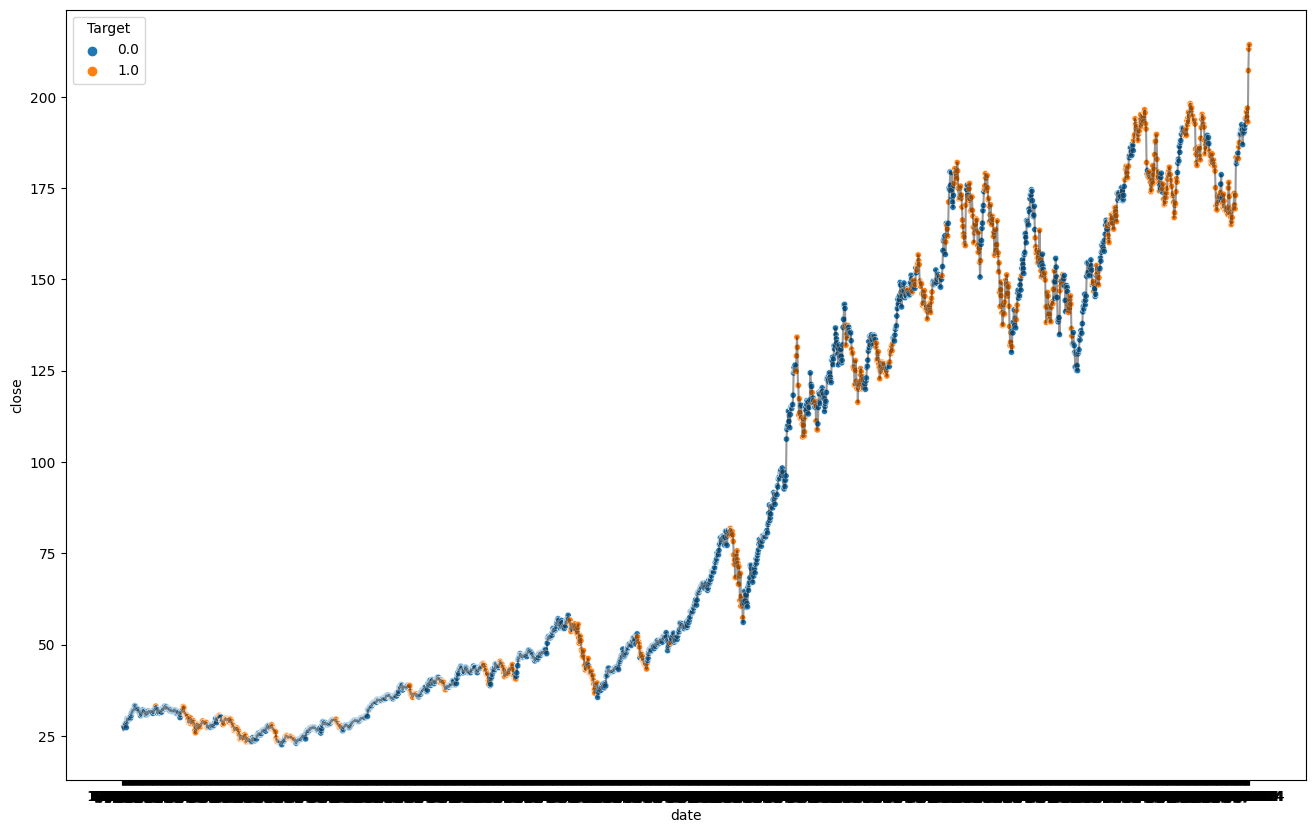

In [48]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=lstm_predictions, x=lstm_predictions.index, y='close', hue='Target',s=20)